In [3]:
import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Conv2D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
import os
import pandas as pd
import numpy as np
from numpy import zeros, newaxis
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_excel('energym.xlsx')

In [3]:
df=dataset.copy()

In [4]:
diff_next = df.pop('Diff Next-Current')

In [5]:
df.head()

,Prev [2] onoff,Prev [1] onoff,HVAC_onoff_HP_sp,Mean_T,Ext_T,Prev [2] Fa_E_HVAC,Prev [1] Fa_E_HVAC,Fa_E_HVAC,Next Fa_E_HVAC
0,0,1,0,19.710479,8.22,975.740705,933.114063,650.015220,14.746716
1,1,0,1,19.752260,8.30,933.114063,650.015220,14.746716,77.246716
2,0,1,1,19.835410,8.38,650.015220,14.746716,77.246716,64.746716
3,1,1,0,19.815562,8.46,14.746716,77.246716,64.746716,14.746716
4,1,0,1,19.834833,8.54,77.246716,64.746716,14.746716,614.185715


In [6]:
def print_errors(y_true, y_pred):
    MAE = round(mean_absolute_error(y_true, y_pred))
    MSE = round(mean_squared_error(y_true, y_pred))
    RMSE = round(mean_squared_error(y_true, y_pred, squared=False))
#     If squared=True returns MSE value, if False returns RMSE value.
    
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('RMSE: ', RMSE)
    
#     MAPE = mean_absolute_percentage_error(y_true, y_pred)
#     R2 = r2_score(y_true, y_pred)
    
#     print('MAPE: ', MAPE)
#     print('R2: ', R2)

def plot(y_test, y_pred):
    time=range(len(y_test))
    plt.plot(time,y_test, 'b', label='y_test')
    plt.plot(time,y_pred, 'r', label='y_pred')
    plt.legend(loc="upper left")
    plt.xlabel("Timesteps")
    plt.ylabel("y_pred and y_test")
    plt.show()

### CNN-LSTM

In [7]:
df2=df.copy()

In [8]:
df2=df2.drop(["Prev [2] onoff", "Prev [1] onoff", "Prev [2] Fa_E_HVAC", "Prev [1] Fa_E_HVAC"],axis=1)

In [9]:
df2.head(10)

,HVAC_onoff_HP_sp,Mean_T,Ext_T,Fa_E_HVAC,Next Fa_E_HVAC
0,0,19.710479,8.22,650.015220,14.746716
1,1,19.752260,8.30,14.746716,77.246716
2,1,19.835410,8.38,77.246716,64.746716
3,0,19.815562,8.46,64.746716,14.746716
4,1,19.834833,8.54,14.746716,614.185715
5,0,19.787042,8.62,614.185715,14.746716
6,0,19.691975,8.70,14.746716,14.746716
7,0,19.581690,8.78,14.746716,14.746716
8,0,19.472829,8.86,14.746716,14.746716
9,0,19.369946,8.94,14.746716,14.746716


In [10]:
X = df2.iloc[:,:-1].values
y = df2.iloc[:,-2].values

In [11]:
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.fit_transform(X)

In [12]:
scaler.inverse_transform(X_norm)

array([[  0.        ,  19.71047899,   8.22      , 650.01522033],
       [  1.        ,  19.75226048,   8.3       ,  14.746716  ],
       [  1.        ,  19.8354096 ,   8.38      ,  77.246716  ],
       ...,
       [  1.        ,  20.81380192,   9.85      ,  14.746716  ],
       [  1.        ,  20.90043405,   9.825     , 613.83749957],
       [  1.        ,  21.01191023,   9.8       , 614.10407214]])

In [13]:
scaled_X = X_norm
scaled_y = y

look_back = 3
forecast_range = 1

In [14]:
X_1=[]
sc=scaled_X
for i in range(len(sc)): 
    lag_end = i + look_back
    forecast_end = lag_end + forecast_range
    if forecast_end > len(sc):
        break
    seq_x = sc[i:lag_end]
#     seq_y = sc[lag_end:forecast_end]
    X_1.append(seq_x)
X_1=np.asanyarray(X_1)
print(X_1.shape)

(175194, 3, 4)


In [15]:
Y_1=[]
sc=scaled_y
for i in range(len(sc)):
    lag_end = i + look_back
    forecast_end = lag_end + forecast_range
    if forecast_end > len(sc):
        break
    #seq_x =sc[i:lag_end]
    seq_y = sc[lag_end:forecast_end]
    Y_1.append(seq_y)
Y_1=np.asanyarray(Y_1)
print(Y_1.shape)

(175194, 1)


In [16]:
Xtrain2, Xtest2, Ytrain2, Ytest2 = train_test_split(X_1, Y_1, test_size = 0.3, random_state = 1)

print(Xtrain2.shape)
print(Ytrain2.shape)
print(Xtest2.shape)
print(Ytest2.shape)

(122635, 3, 4)
(122635, 1)
(52559, 3, 4)
(52559, 1)


In [17]:
input_shape=(Xtrain2.shape[1], Xtrain2.shape[2])

In [18]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

multivariate_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

history = multivariate_cnn_lstm.fit(Xtrain2, Ytrain2, validation_data=(Xtest2, Ytest2), epochs=5, verbose=1) #batch_size=16,

Epoch 1/5
3833/3833 [==============================] - 69s 12ms/step - loss: 22174.0195 - val_loss: 16712.5742
Epoch 2/5
3833/3833 [==============================] - 45s 12ms/step - loss: 17086.6953 - val_loss: 16525.1816
Epoch 3/5
3833/3833 [==============================] - 45s 12ms/step - loss: 16815.7109 - val_loss: 16448.6230
Epoch 4/5
3833/3833 [==============================] - 46s 12ms/step - loss: 16669.2773 - val_loss: 16310.0840
Epoch 5/5
3833/3833 [==============================] - 38s 10ms/step - loss: 16524.7695 - val_loss: 16064.8818


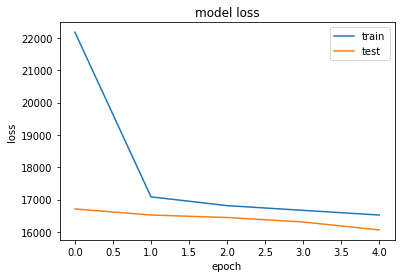

In [19]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
Y_pred2=multivariate_cnn_lstm.predict(Xtest2)

1643/1643 [==============================] - 7s 4ms/step


In [21]:
Ypred2=[]
for i in Y_pred2:
    Ypred2.append(i[0])

In [22]:
print_errors(Ytest2,Ypred2)

MAE:  70
MSE:  16065
RMSE:  127


<IPython.core.display.Javascript object>


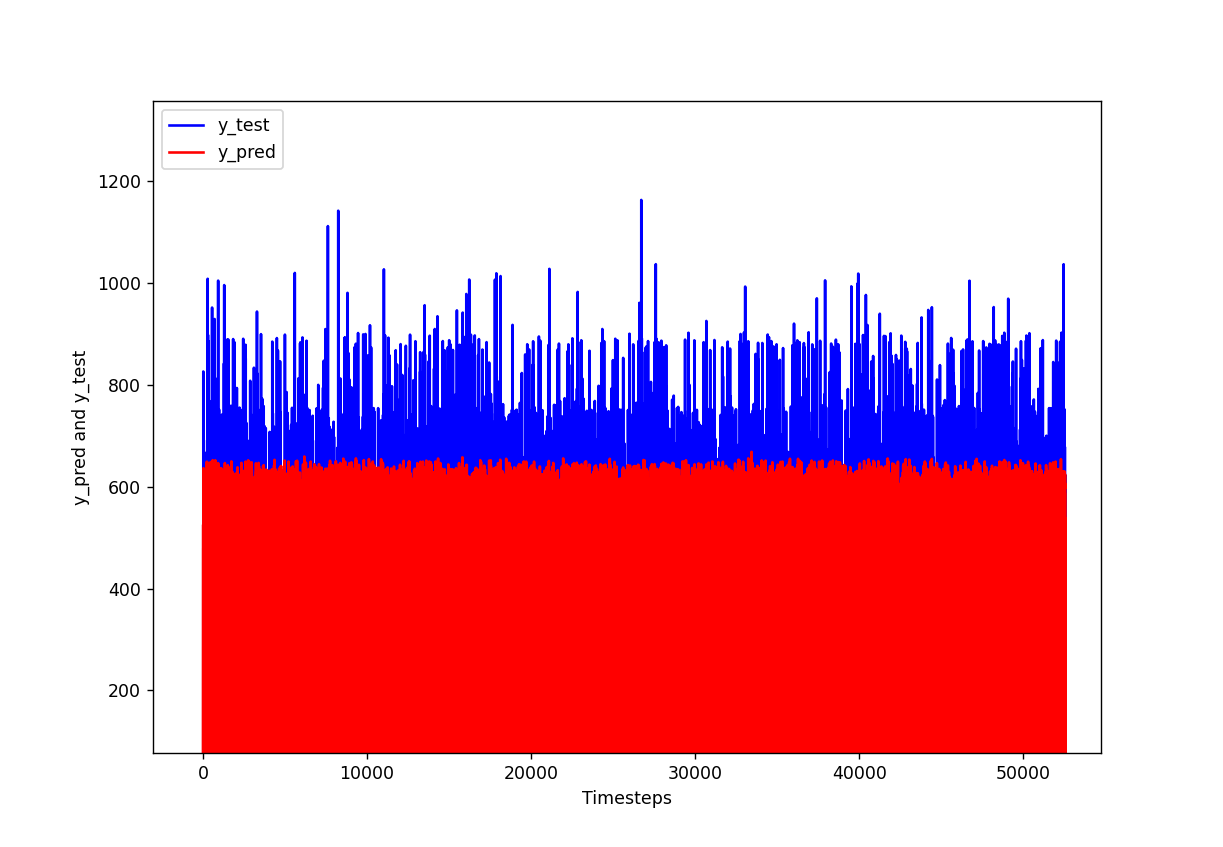

In [23]:
%matplotlib notebook
plot(Ytest2,Ypred2)

In [24]:
for i in range(20,30):
    Xt=scaler.inverse_transform(Xtest2[i])
    Xt=scaler.transform(Xt)
#     Xt=Xtest2[i]
    Xt = np.expand_dims(Xt, axis = 0)
    print("Prediction: ", multivariate_cnn_lstm.predict(Xt), "Real: ", Ytest2[i])

1/1 [==============================] - 0s 64ms/step
Prediction:  [[14.498467]] Real:  [0.01720454]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[7.012661]] Real:  [0.07232468]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[9.280922]] Real:  [1.86053428]
1/1 [==============================] - 0s 20ms/step
Prediction:  [[9.082139]] Real:  [1.8433395]
1/1 [==============================] - 0s 17ms/step
Prediction:  [[20.504597]] Real:  [0.]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[636.39197]] Real:  [615.90393773]
1/1 [==============================] - 0s 17ms/step
Prediction:  [[513.0992]] Real:  [619.55171803]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[141.45378]] Real:  [50.01719984]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[32.350388]] Real:  [14.76390739]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[372.08197]] Real:  [621.99641856]


In [25]:
scaler.inverse_transform(X_norm)

array([[  0.        ,  19.71047899,   8.22      , 650.01522033],
       [  1.        ,  19.75226048,   8.3       ,  14.746716  ],
       [  1.        ,  19.8354096 ,   8.38      ,  77.246716  ],
       ...,
       [  1.        ,  20.81380192,   9.85      ,  14.746716  ],
       [  1.        ,  20.90043405,   9.825     , 613.83749957],
       [  1.        ,  21.01191023,   9.8       , 614.10407214]])

### Control Pipeline

In [4]:
def create_all_sp(n):
    sp=np.zeros((2**n,n))
    
    for i in range(0,n):
        c=1
        for j in range(0,2**n):
            if not(j%(2**(n-i-1))):
                c=change(c)
            sp[j,i]=c
            
    return sp

def change(c):
    if (c==0.0):
        return 1.0
    else:
        return 0.0

In [5]:
sp = create_all_sp(3)
print(sp)

[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]


In [28]:
Xtest2.shape

(52559, 3, 4)

In [31]:
# Xtest=[]
# for i in range(len(Xtest2)):
#     Xtest.append(scaler.inverse_transform(Xtest2[i]))

In [32]:
# x=scaler.transform(Xtest[0])
# x = np.expand_dims(x, axis = 0)
# print(multivariate_cnn_lstm.predict(x))

1/1 [==============================] - 0s 19ms/step
[[37.753372]]


In [51]:
# recreation of the dataset in team of 3
X_2=[]
sc=X
for i in range(len(sc)): 
    lag_end = i + look_back
    forecast_end = lag_end + forecast_range
    if forecast_end > len(sc):
        break
    seq_x = sc[i:lag_end]
#     seq_y = sc[lag_end:forecast_end]
    X_2.append(seq_x)
X_2=np.asanyarray(X_2)
print(X_2.shape)

(175194, 3, 4)


In [78]:
x

array([[[ 0.99969753, -0.62709048, -1.08995069, -0.43553239],
        [ 0.99969753, -0.60373229, -1.08995069,  1.73654623],
        [-1.00030256, -0.61175852, -1.08995069,  1.73986732]]])

In [100]:
for obs in range(len([0,1,2,3,4,5])):              # range(len(X_2))
    x=scaler.transform(X_2[obs])
    x = np.expand_dims(x, axis = 0)
    min_e = multivariate_cnn_lstm.predict(x, verbose=0)[0][0]
    min_sp = []
    
    for setpoints in sp:                   # ie [0,1,0],[0,1,1]...
        for i in range(len(setpoints)):
            X_2[obs][i][0]=setpoints[i]
            
        x = scaler.transform(X_2[obs])
        x = np.expand_dims(x, axis = 0)
        consumption = multivariate_cnn_lstm.predict(x, verbose=0)[0]
        print("For observation",obs, "as \n", X_2[obs], "\n Predicted consumption is: ", consumption, "\n")
        
        if consumption <= min_e:
            min_e = consumption
            min_sp = setpoints
            
    print("Mimimun consumption ", min_e, " is achieved when the setpoint are ", min_sp, "\n")
            
#         print(X_2[obs],"\n")

For observation 0 as 
 [[  0.          19.71047899   8.22       650.01522033]
 [  0.          19.75226048   8.3         14.746716  ]
 [  0.          19.8354096    8.38        77.246716  ]] 
 Predicted consumption is:  [31.254099] 

For observation 0 as 
 [[  0.          19.71047899   8.22       650.01522033]
 [  0.          19.75226048   8.3         14.746716  ]
 [  1.          19.8354096    8.38        77.246716  ]] 
 Predicted consumption is:  [621.4791] 

For observation 0 as 
 [[  0.          19.71047899   8.22       650.01522033]
 [  1.          19.75226048   8.3         14.746716  ]
 [  0.          19.8354096    8.38        77.246716  ]] 
 Predicted consumption is:  [45.48926] 

For observation 0 as 
 [[  0.          19.71047899   8.22       650.01522033]
 [  1.          19.75226048   8.3         14.746716  ]
 [  1.          19.8354096    8.38        77.246716  ]] 
 Predicted consumption is:  [639.1232] 

For observation 0 as 
 [[  1.          19.71047899   8.22       650.0152203

For observation 4 as 
 [[  0.          19.83483323   8.54        14.746716  ]
 [  1.          19.78704177   8.62       614.18571473]
 [  1.          19.69197519   8.7         14.746716  ]] 
 Predicted consumption is:  [634.30634] 

For observation 4 as 
 [[  1.          19.83483323   8.54        14.746716  ]
 [  0.          19.78704177   8.62       614.18571473]
 [  0.          19.69197519   8.7         14.746716  ]] 
 Predicted consumption is:  [36.38582] 

For observation 4 as 
 [[  1.          19.83483323   8.54        14.746716  ]
 [  0.          19.78704177   8.62       614.18571473]
 [  1.          19.69197519   8.7         14.746716  ]] 
 Predicted consumption is:  [610.36383] 

For observation 4 as 
 [[  1.          19.83483323   8.54        14.746716  ]
 [  1.          19.78704177   8.62       614.18571473]
 [  0.          19.69197519   8.7         14.746716  ]] 
 Predicted consumption is:  [66.94436] 

For observation 4 as 
 [[  1.          19.83483323   8.54        14.746716

In [82]:
a=(multivariate_cnn_lstm.predict(x, verbose=0))

In [72]:
sp[2][2]

0.0

In [58]:
print((X_2[0]))
print((X_2[1]))
print((X_2[2]))

[[  0.          19.71047899   8.22       650.01522033]
 [  1.          19.75226048   8.3         14.746716  ]
 [  1.          19.8354096    8.38        77.246716  ]]
[[ 1.         19.75226048  8.3        14.746716  ]
 [ 1.         19.8354096   8.38       77.246716  ]
 [ 0.         19.81556239  8.46       64.746716  ]]
[[ 1.         19.8354096   8.38       77.246716  ]
 [ 0.         19.81556239  8.46       64.746716  ]
 [ 1.         19.83483323  8.54       14.746716  ]]


In [6]:
for i in sp:
    print(i)

[0. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 1.]
[1. 0. 0.]
[1. 0. 1.]
[1. 1. 0.]
[1. 1. 1.]


In [12]:
for setpoints in sp:
    for i in setpoints:
        print(i)
    print("\n")

0.0
0.0
0.0


0.0
0.0
1.0


0.0
1.0
0.0


0.0
1.0
1.0


1.0
0.0
0.0


1.0
0.0
1.0


1.0
1.0
0.0


1.0
1.0
1.0


